In [1]:
import numpy as np
from utils import *
import scipy as sp
from scipy.integrate import solve_ivp, cumulative_trapezoid
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt
import matplotlib.pyplot as plt
from models import *
import pandas as pd
from constants import *
from  scipy.io import loadmat
# autoreload modules
%load_ext autoreload
%autoreload 2

### Test simple constant Yasso model

In [48]:
# test the Yasso model implementation similar to Sierra et al. 2018
def build_Yasso_model(mat,Tmin,Tmax,Pa):
    a_i=np.array([0.66, 4.3, 0.35, 0.22, 0.0033])
    b1 = 7.6e-2; b2 = -8.9e-4; gamma = -1.27;
    p1=0.32;p2=0.01;p3=0.93;p4=0.34;p5=0;p6=0;p7=0.035;p8=0.005;p9=0.01;p10=0.0005;p11=0.03;p12=0.92;pH=0.04

    Ap=-np.diag(np.ones(5))
    Ap[0,1]=p1; Ap[0,2]=p2; Ap[0,3]=p3; Ap[1,0]=p4; Ap[1,2]=p5; Ap[1,3]=p6
    Ap[2,0]=p7; Ap[2,1]=p8; Ap[2,3]=p9; Ap[3,0]=p10; Ap[3,1]=p11; Ap[3,2]=p12; Ap[4,:4]=pH

    u= np.array([10,0,0,0,0])

    def A_t(t):
        T =  mat + 0.5*(Tmax-Tmin)*np.sin(2*np.pi*t) # assume the time is in years
        kC = a_i*np.exp(b1*T + b2*T**2)*(1-np.exp(gamma*Pa))
        A1=np.diag(kC)
        A=Ap @ A1

        return A
    
    return A_t,u,Ap



In [49]:
# age distribution calculation based on Sierra et al. 2018
def calc_age_dist(A,u,ages):
    d = A.shape[0]
    one = np.ones((d,1))
    beta = u/u.sum()
    zT = -1 * one.T @ A
    xss = (-1 * np.linalg.inv(A)) @ u
    X = np.diag(xss)
    eta = xss/xss.sum()
    age_dens = np.array([zT @ sp.linalg.expm(A * a) @ eta for a in ages])
    return age_dens
    # xss = (-1 * solve(A)) %*% u


In [ ]:
# age distribution calculation based on Sierra et al. 2018
def calc_age_dist_cdf(A,u,ages):
    d = A.shape[0]
    one = np.ones((d,1))
    beta = u/u.sum()
    zT = one.T
    xss = (-1 * np.linalg.inv(A)) @ u
    X = np.diag(xss)
    eta = xss/xss.sum()
    age_dens = 1 - np.array([zT @ sp.linalg.expm(A * a) @ eta for a in ages])
    return age_dens


Analytical solution

In [135]:
A_t,u,Ap = build_Yasso_model(0,20,30,1e10)
A = A_t(0)
ages = range(1,10000)
pA = calc_age_dist(A,u,ages)
cdfA = calc_age_dist_cdf(A,u,ages)

Empirical solution

In [ ]:
def dY(t, y, A=A, u=u):
    return u + A @ y
unlabled = solve_ivp(dY, (0, 10000), xss, t_eval=ages, args=(A, 0))
labeled = solve_ivp(dY, (0, 10000), np.zeros(5), t_eval=ages, args=(A, u))
totC = unlabled.y.sum(axis=0) + labeled.y.sum(axis=0)
empirical_age_cdf = labeled.y.sum(axis=0) / totC

Check that they match

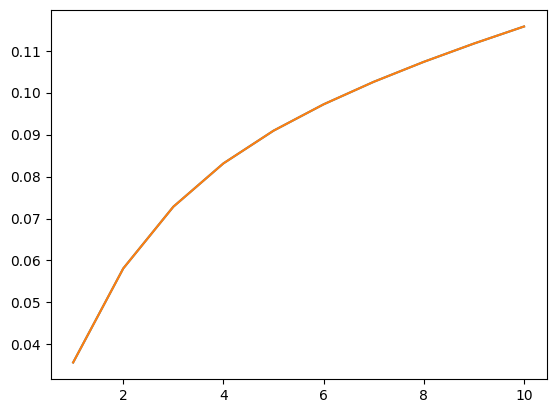

In [ ]:
plt.plot(ages[:10], empirical_age_cdf[:10])
plt.plot(ages[:10], cdfA[:10])

assert np.allclose(empirical_age_cdf, cdfA.squeeze(), rtol=1e-4), "CDFs do not match!"

### Test JSBACH (Yasso) model with varying inputs

In [185]:

# from https://pure.mpg.de/rest/items/item_3279802_26/component/file_3316522/content#page=107.51 and 
# https://gitlab.dkrz.de/icon/icon-model/-/blob/release-2024.10-public/externals/jsbach/src/carbon/mo_carbon_process.f90
a_i=np.array([0.72, 5.9, 0.28, 0.031]) # Eq. 6.28
a_h = 0.0016 # Eq. 6.34
b1 = 9.5e-2; b2 = -1.4e-3; gamma = -1.21; # Eq. 6.30 - T in C and P in m/yr
phi1 = -1.71; phi2 = 0.86; r = -0.306; # Eq. 6.31

# Download temperature and precipitation data from the JSBACH model
download_file("https://gcbo-opendata.s3.eu-west-2.amazonaws.com/trendyv12-gcb2023/JSBACH/S3/JSBACH_S3_tas.nc", "../data/model_params/JSBACH", "JSBACH_S3_tas.nc")
download_file("https://gcbo-opendata.s3.eu-west-2.amazonaws.com/trendyv12-gcb2023/JSBACH/S3/JSBACH_S3_pr.nc", "../data/model_params/JSBACH", "JSBACH_S3_pr.nc")
download_file("https://gcbo-opendata.s3.eu-west-2.amazonaws.com/trendyv12-gcb2023/JSBACH/S3/JSBACH_S3_npp.nc", "../data/model_params/JSBACH", "JSBACH_S3_npp.nc")

# Load the JSBACH forcing data and calculate the monthly means
JSBACH_tas = xr.open_dataarray('../data/model_params/JSBACH/JSBACH_S3_tas.nc').groupby("time.month").mean()
JSBACH_pr = xr.open_dataarray('../data/model_params/JSBACH/JSBACH_S3_pr.nc').groupby("time.month").mean()
JSBACH_npp = xr.open_dataarray('../data/model_params/JSBACH/JSBACH_S3_npp.nc').groupby("time.month").mean()

site_data = pd.read_csv('../results/tropical_sites_14C_turnover.csv')

JSBACH_config = namedtuple('Config', ['a_i', 'a_h', 'b1', 'b2', 'gamma', 'phi1', 'phi2', 'r'])
JSBACH_config.a_i = a_i
JSBACH_config.a_h = a_h
JSBACH_config.b1 = b1
JSBACH_config.b2 = b2
JSBACH_config.gamma = gamma
JSBACH_config.phi1 = phi1
JSBACH_config.phi2 = phi2
JSBACH_config.r = r


row = site_data.iloc[0]

def get_env_params(row):
    """Get the environmental parameters for a given site."""
    I = JSBACH_npp.sel(longitude=row.loc['Longitude'], latitude=row.loc['Latitude'], method='nearest').values * SECS_PER_DAY * DAYS_PER_YEAR * 1000  # convert kgC/m2/s to gC/m2/yr
    T = JSBACH_tas.sel(longitude=row.loc['Longitude'], latitude=row.loc['Latitude'], method='nearest').values - T_MELT  # convert K to C
    P = JSBACH_pr.sel(longitude=row.loc['Longitude'], latitude=row.loc['Latitude'], method='nearest').values * SECS_PER_DAY * DAYS_PER_YEAR / 1000  # convert kg/m2/s to m/yr
    d = 4  # from WoodLitterSize in https://gitlab.dkrz.de/icon/icon-model/-/blob/release-2024.10-public/externals/jsbach/data/lctlib_nlct21.def it is 4  # Example diameter values in cm
    return namedtuple('EnvParams', ['I', 'T', 'P', 'd'])(I, T, P, d)
# JSBACH_env_params = namedtuple('EnvParams', ['I','T', 'P', 'd'])
# JSBACH_env_params.I = JSBACH_npp.sel(longitude=row.loc['Longitude'],latitude=row.loc['Latitude'],method='nearest').values
# JSBACH_env_params.T = JSBACH_tas.sel(longitude=row.loc['Longitude'],latitude=row.loc['Latitude'],method='nearest').values - T_MELT # convert K to C - - T_MELT
# JSBACH_env_params.P = JSBACH_pr * SECS_PER_DAY * DAYS_PER_YEAR / 1000 # convert kg/m2/s to m/yr - *sec_per_year/1000._wp
# JSBACH_env_params.d = 4 

JSBACH_env_params = get_env_params(row)

JSBACH_model = JSBACH(config=JSBACH_config,
                 env_params=JSBACH_env_params)

Data already downloaded
Data already downloaded
Data already downloaded


In [ ]:

JSBACH_model = JSBACH(config=JSBACH_config,
                 env_params=JSBACH_env_params)
env_params_no_input = namedtuple('EnvParams', ['I', 'T', 'P', 'd'])(np.zeros_like(JSBACH_env_params.I), JSBACH_env_params.T, JSBACH_env_params.P, JSBACH_env_params.d)
JSBACH_model_no_inputs = JSBACH(config=JSBACH_config,
                 env_params=env_params_no_input)
ts = np.logspace(-3, 4, 1000)  # time in years
labeled = solve_ivp(JSBACH_model._dX, (0, 10000), np.zeros(18), t_eval=ts)

unlabeled = solve_ivp(JSBACH_model_no_inputs._dX, (0, 10000), labeled.y[:,-1], t_eval=ts)

In [204]:
totC = unlabeled.y.sum(axis=0) + labeled.y.sum(axis=0)
age_CDF = labeled.y.sum(axis=0) / totC

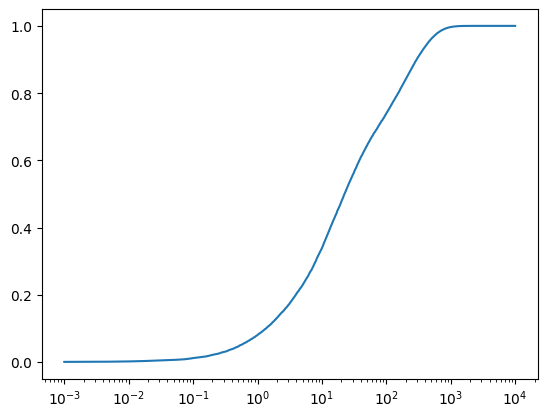

In [205]:
plt.semilogx(ts, age_CDF)

### Test for CLM4.5

In [2]:
# load soil depth mat file 
fn = '../data/CLM5_global_simulation/soildepth.mat'
mat = loadmat(fn)
zisoi = mat['zisoi'].squeeze()
zsoi = mat['zsoi'].squeeze()
dz = mat['dz'].squeeze()
dz_node = mat['dz_node'].squeeze()

# load gridded nc file with the inputs, initial values, and the environmental variables
global_da = xr.open_dataset('../data/CLM5_global_simulation/global_demo_in.nc')
global_da = global_da.rename({'LON':'x','LAT':'y'})
def fix_lon(ds):
    ds['x'] = xr.where(ds['x']>=180,ds['x']-360,ds['x'])
    return ds.sortby('x')

global_da = fix_lon(global_da)
global_da = global_da.rio.write_crs("EPSG:4326", inplace=True)

# define model parameters
CLM_params = xr.open_dataset('../data/CLM5_global_simulation/clm5_params.c171117.nc')
taus = np.array([CLM_params['tau_cwd'],CLM_params['tau_l1'],CLM_params['tau_l2_l3'],CLM_params['tau_l2_l3'],CLM_params['tau_s1'],CLM_params['tau_s2'],CLM_params['tau_s3']]).squeeze()
Gamma_soil = 1e-4 
F_soil = 0

/var/folders/6f/_716m82x3n32hwr7x9h4fp2c0000gp/T/ipykernel_97811/4085962492.py:20: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  CLM_params = xr.open_dataset('../data/CLM5_global_simulation/clm5_params.c171117.nc')


In [3]:
config = ConfigParams(decomp_depth_efolding=0.5, taus=taus, Gamma_soil=Gamma_soil, F_soil=F_soil,
                      zsoi=zsoi, zisoi=zisoi, dz=dz, dz_node=dz_node, nlevels=10, npools=7)
global_data = GlobalData(global_da)

In [ ]:
site_data = pd.read_csv('../results/tropical_sites_14C_turnover.csv')
row = site_data.iloc[0]
ldd = global_data.make_ldd(*row[['Latitude','Longitude']].values)
CLM_model = CLM5(config, ldd)
ldd_no_input = LocDependentData(w=ldd.w, t=ldd.t, o=ldd.o, n=ldd.n, sand=ldd.sand, I=xr.zeros_like(ldd.I), X0=ldd.X0)
CLM_model_no_input = CLM5(config, ldd_no_input)
ts = np.logspace(-1, 4, 1000)  # time in years
labeled = solve_ivp(CLM_model._dX, (0, 10_000), np.zeros(70), t_eval=ts)#, method = 'LSODA')
unlabeled = solve_ivp(CLM_model_no_input._dX, (0, 10_000), labeled.y[:,-50:].mean(axis=1), t_eval=ts)#, method = 'LSODA')

totC = unlabeled.y.sum(axis=0) + labeled.y.sum(axis=0)
age_CDF = labeled.y.sum(axis=0) / totC

(0.0, 1.0)

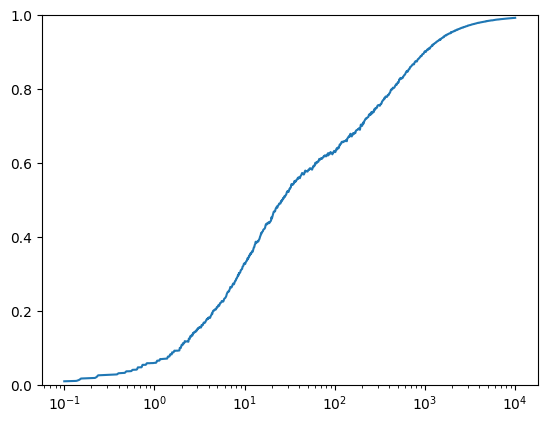

In [22]:
plt.semilogx(ts, age_CDF)
plt.ylim(0, 1)

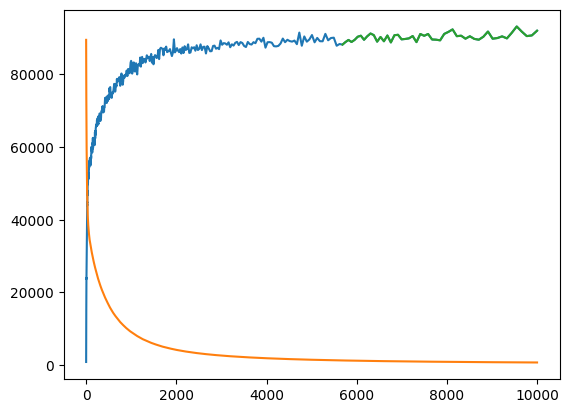

In [21]:
plt.plot(ts,labeled.y.sum(axis=0).T)
plt.plot(ts,unlabeled.y.sum(axis=0).T)

plt.plot(ts[-50:], labeled.y[:,-50:].sum(axis=0).T)

In [7]:
site_data = pd.read_csv('../results/tropical_sites_14C_turnover.csv')
row = site_data.iloc[0]
ldd_jax = global_data.make_ldd_jax(*row[['Latitude','Longitude']].values)
CLM_model_jax = CLM5_jax(config, ldd_jax)
# term = ODETerm(ode)
# solver = Dopri5()
# t_max = 30_000
# # ts = jnp.concatenate([jnp.arange(0,1.01,0.01),jnp.arange(2,t_max,1)])
# CLM5_ts = jnp.logspace(-2,jnp.log10(t_max),1000)
# solution = diffeqsolve(term, solver, t0=0, t1=t_max, dt0=0.1, y0=u,max_steps=1000000,saveat=SaveAt(ts = CLM5_ts))

XlaRuntimeError: UNIMPLEMENTED: default_memory_space is not supported.

In [ ]:

JSBACH_model = JSBACH(config=JSBACH_config,
                 env_params=JSBACH_env_params)
env_params_no_input = namedtuple('EnvParams', ['I', 'T', 'P', 'd'])(np.zeros_like(JSBACH_env_params.I), JSBACH_env_params.T, JSBACH_env_params.P, JSBACH_env_params.d)
JSBACH_model_no_inputs = JSBACH(config=JSBACH_config,
                 env_params=env_params_no_input)
ts = np.logspace(-3, 4, 1000)  # time in years
labeled = solve_ivp(JSBACH_model._dX, (0, 10000), np.zeros(18), t_eval=ts)

unlabeled = solve_ivp(JSBACH_model_no_inputs._dX, (0, 10000), labeled.y[:,-1], t_eval=ts)

In [ ]:
CLM5_site_cum_age_dist = []
for i, row in tqdm(unique_tropical_sites.iterrows()):
    ldd = global_data.make_ldd(*row[['Latitude','Longitude']].values)
    CLM_model = CLM_vertical(config, ldd)

    # define the key matrices for the calculation
    A = jnp.array(CLM_model.A)
    V = jnp.array(CLM_model.V)
    K_t = jnp.stack([make_K_matrix(taus, zsoi,
                        ldd.w[t,:], ldd.t[t,:], ldd.o[t,:], ldd.n[t,:],
                        config.decomp_depth_efolding, config.nlevels) for t in range(12)])


    u = jnp.array(ldd.I.mean(dim='TIME1').values)


    def ode(t,y,args):
        # define the ode for an impulse input
        t_ind = jnp.array((t % (1/12))*12*12,int)    
        A_t = jnp.subtract(jnp.dot(A, K_t[t_ind,:,:]), V)
        return jnp.dot(A_t , y)


    # sole the ode
    term = ODETerm(ode)
    solver = Dopri5()
    t_max = 30_000
    # ts = jnp.concatenate([jnp.arange(0,1.01,0.01),jnp.arange(2,t_max,1)])
    CLM5_ts = jnp.logspace(-2,jnp.log10(t_max),1000)
    solution = diffeqsolve(term, solver, t0=0, t1=t_max, dt0=0.1, y0=u,max_steps=1000000,saveat=SaveAt(ts = CLM5_ts))

    ys = solution.ys.sum(axis=1)
    CLM5_site_cum_age_dist.append(cumtrapz(ys,x=CLM5_ts)/trapz(ys,x=CLM5_ts))

CLM5_site_cum_age_dist = np.stack(CLM5_site_cum_age_dist)
